In [51]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns

import sys
sys.path.append('/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/src/')
import _config, _lib

sys.path.append('/home/unix/maxwshen/')
from mylib import util

notebook_nm = 'fig_compare_truth_to_inference'
results_dir = _config.RESULTS_PLACE + f'{notebook_nm}/'
util.ensure_dir_exists(results_dir)

In [66]:
# Edit me and run all cells below
pnum = 1

if pnum in [2, 3]:
    datagroup = 'simple'
else:
    datagroup = 'simple_p1'

In [67]:
## Load data

true_df = pd.read_csv(f'/ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/out/data_multi/pv_groundtruth_0.0pct_t5_p{pnum}.csv')

true_df['Abbrev genotype'] = [_lib.full_to_abbrev(s) for s in true_df['Full genotype']]
true_df = true_df.drop(columns = 'Full genotype')

true_df.to_csv(results_dir + f'p{pnum}_ground_truth.csv')



In [68]:
true_melt_df = true_df.melt(
    id_vars = 'Abbrev genotype',
    var_name = 'Time',
    value_name = 'Frequency (%)',
)
true_melt_df = true_melt_df.rename(columns = {'Frequency (%)': 'Observed frequency'})
true_fq_col = 'Observed frequency'
true_melt_df[true_fq_col] *= 100

gts = sorted(list(set(true_df['Abbrev genotype'])))
# colors = sns.color_palette('hls', int(len(gts) * 1.5))
colors = sns.hls_palette(n_colors = int(len(gts) * 1.5), s = 0.95, l = 0.65)
master_palette = {gt: color for gt, color in zip(gts, colors)}

## Load inference

In [69]:
## Load an inference result

def load_inferred(modelexp = 'modelexp_illumina', dataset_nm = '', title = ''):
    inp_dir_g = _config.OUT_PLACE + f'g_collate_exps/'

    # Pick from /data/modelexp_x.csv, dataset col
    modelexp_design = pd.read_csv(_config.DATA_DIR + f'{modelexp}.csv')
    row = modelexp_design[modelexp_design['dataset'] == dataset_nm].iloc[0]
    tdf_dict = _lib.load_true_df_from_row(row)
    true_df = tdf_dict['true_df']
    idx_to_col = tdf_dict['idx_to_col']
    true_df_name = tdf_dict['memoize_key']
    nm = row['Name']

    df_fn = f'{inp_dir_g}/{modelexp}/genotype_matrix_{nm}.csv'

    df = pd.read_csv(df_fn, index_col = 0)
    
    df['Abbrev genotype'] = df.index
#     df['Full genotype'] = [_lib.abbrev_to_full(s, true_df) for s in list(df['Abbrev genotype'])]
    df = df.rename(columns = idx_to_col)
    df = df.reset_index(drop = True)
#     df = df.drop(columns = ['Full genotype'])

    melt_df = df.melt(
        id_vars = 'Abbrev genotype',
        var_name = 'Time',
        value_name = 'Frequency (%)',
    )
    melt_df['Frequency (%)'] *= 100
    
    return melt_df


pred_df = load_inferred(
    modelexp = f'modelexp_{datagroup}_rs', 
    dataset_nm = f'{datagroup}--pace_num-{pnum}--threshold-5--read_len-100--min_gt_frequency-0.0--proposal_type-smart',
)
pred_df = pred_df.rename(columns = {'Frequency (%)': 'Predicted frequency (%)'})
pred_fq_col = 'Predicted frequency (%)'

inference_nm = f'p{pnum}_rl100'

pv_pred_df = pred_df.pivot(index = 'Abbrev genotype', columns = 'Time', values = 'Predicted frequency (%)')
pv_pred_df.to_csv(results_dir + f'{inference_nm}.csv')

In [70]:
id_cols = ['Abbrev genotype', 'Time']
dfm = true_melt_df.merge(pred_df, on = id_cols, how = 'outer')
dfm = dfm.fillna(value = 0)

dfm.head()

,Abbrev genotype,Time,Observed frequency,Predicted frequency (%)
0,..........................G,t01,0.080099,0.055921
1,..........................N,t01,0.033816,0.052745
2,.........................I.,t01,0.014145,0.049006
3,........................T..,t01,0.050814,0.051829
4,........................T.G,t01,0.000000,0.000000


In [71]:
ts = sorted(list(set(dfm['Time'])))
t_to_sample_num = {t: idx + 1 for idx, t in enumerate(ts)}
dfm['Sample number'] = [t_to_sample_num[t] for t in dfm['Time']]

dfm.head()

,Abbrev genotype,Time,Observed frequency,Predicted frequency (%),Sample number
0,..........................G,t01,0.080099,0.055921,1
1,..........................N,t01,0.033816,0.052745,1
2,.........................I.,t01,0.014145,0.049006,1
3,........................T..,t01,0.050814,0.051829,1
4,........................T.G,t01,0.000000,0.000000,1


## Pearson correlation across time

In [72]:
from collections import defaultdict
from scipy.stats import pearsonr
dd = defaultdict(list)


for t in sorted(list(set(dfm['Time']))):
    dfs = dfm[dfm['Time'] == t]
    
    pr, pval = pearsonr(dfs[true_fq_col], dfs[pred_fq_col])
    dd['Time'].append(t)
    dd['R'].append(pr)
    dd['Sample number'].append(dfs['Sample number'].iloc[0])
    
stats_df = pd.DataFrame(dd)

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_compare_truth_to_inference/time_r_p1_rl100.pdf ...


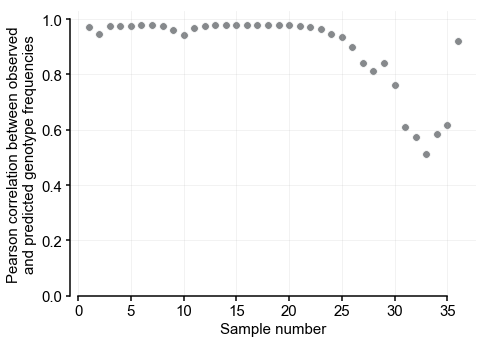

In [73]:
#
import matplotlib
matplotlib.rc('font', family = 'Arial', size = 15)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#
fig, ax = plt.subplots(figsize = (7, 5))


sns.scatterplot(
    x = 'Sample number',
    y = 'R',
    data = stats_df,
    color = '#86898c',
    s = 60,
)
sns.despine()
plt.grid(alpha = 0.2)
# plt.xticks(np.arange(0, 528 + 48, 48))
plt.ylim([0, 1.03])
# plt.xlim([-10, 528 + 5])

plt.xlabel('Sample number')
plt.ylabel('Pearson correlation between observed\nand predicted genotype frequencies')

plt.tight_layout()

##

sns.despine(trim = True)
ax.tick_params(length = 4.5, color = 'black', width = 1.5)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('black')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

out_fn = results_dir + f'time_r_{inference_nm}.pdf'
print(f'Saving to {out_fn} ...')
plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##

In [74]:
print(f'Pearsonr stats across samples')
stats_df['R'].describe()

Pearsonr stats across samples


count    36.000000
mean      0.894260
std       0.138881
min       0.511750
25%       0.885308
50%       0.968368
75%       0.976648
max       0.978369
Name: R, dtype: float64

Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_compare_truth_to_inference/time_r_strip_p1_rl100.pdf ...


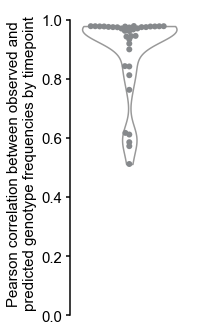

In [75]:
#
import matplotlib
matplotlib.rc('font', family = 'Arial', size = 15)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#
fig, ax = plt.subplots(figsize = (3, 5))


sns.violinplot(
    y = 'R',
    data = stats_df,
    color = 'white',
    alpha = 0.1,
    cut = 0,
    inner = None,
    bw = 0.3,
    fliersize = 0,
)
sns.swarmplot(
    y = 'R',
    data = stats_df,
    color = '#86898c',
    alpha = 1,
    s = 6,
)
sns.despine()
# plt.grid(alpha = 0.2)
# plt.xticks(np.arange(0, 528 + 48, 48))
plt.ylim([0, 1.03])
# plt.xlim([-10, 528 + 5])
ax.xaxis.set_ticks_position('none') 

# plt.xlabel('Time (h)')
plt.ylabel('Pearson correlation between observed and\npredicted genotype frequencies by timepoint')

plt.tight_layout()

##

sns.despine(trim = True)
ax.tick_params(length = 4.5, color = 'black', width = 1.5)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('black')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

out_fn = results_dir + f'time_r_strip_{inference_nm}.pdf'
print(f'Saving to {out_fn} ...')
plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##

In [76]:
stats_df.sort_values(by = 'R', ascending = True).iloc[:10]

,Time,R,Sample number
32,t82,0.511750,33
31,t81,0.572216,32
33,t83,0.585482,34
30,t80,0.611420,31
34,t84,0.616971,35
29,t79,0.762654,30
27,t48,0.812101,28
28,t49,0.841689,29
26,t47,0.842795,27
25,t46,0.899480,26


## Genotype scatter plot

Plotting only top 30 genotypes
Saving to /ahg/regevdata/projects/CRISPR-libraries/prj2/evolution/abe8e/results/fig_compare_truth_to_inference/gts_scatter_p1_rl100.pdf ...


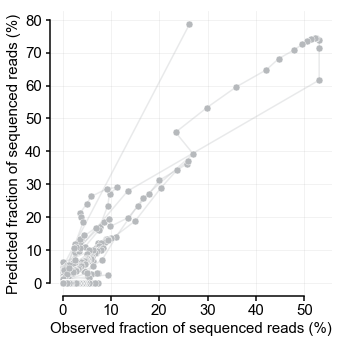

In [77]:
#
import matplotlib
matplotlib.rc('font', family = 'Arial', size = 15)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
#
fig, ax = plt.subplots(figsize = (5, 5))

# Truncate
test_dfs = dfm.groupby('Abbrev genotype')['Observed frequency'].agg('max').reset_index()
top_n = 30
top_gts = list(test_dfs.sort_values(by = 'Observed frequency', ascending = False)['Abbrev genotype'].iloc[:top_n])
print(f'Plotting only top {top_n} genotypes')


# for gt in set(dfm['Abbrev genotype']):
for gt in top_gts:
    dfs = dfm[dfm['Abbrev genotype'] == gt]
    
    # Dots
    plt.plot(
        dfs[true_fq_col],
        dfs[pred_fq_col],
        # color = master_palette[gt] if gt in master_palette else '#b6b9bc',
        color = '#b6b9bc',
        marker = 'o',
        markeredgecolor = 'white',
        markeredgewidth = 0.5,
        markersize = 7,
        linewidth = 0,
    )
    
    # Lines
    plt.plot(
        dfs[true_fq_col],
        dfs[pred_fq_col],
        # color = master_palette[gt] if gt in master_palette else '#b6b9bc',
        color = '#b6b9bc',
        markersize = 0,
        linewidth = 1.5,
        alpha = 0.3,
    )

sns.despine()
plt.grid(alpha = 0.2)
plt.xlabel('Observed fraction of sequenced reads (%)')
plt.ylabel('Predicted fraction of sequenced reads (%)')
# plt.xlim(left = 0, right = 101)
# plt.ylim(bottom = 0, top = 101)

plt.tight_layout()

##

sns.despine(trim = True)
ax.tick_params(length = 4.5, color = 'black', width = 1.5)
for axis in ['bottom', 'left']:
    ax.spines[axis].set_linewidth(1.5)
    ax.spines[axis].set_color('black')

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

out_fn = results_dir + f'gts_scatter_{inference_nm}.pdf'
print(f'Saving to {out_fn} ...')
plt.savefig(out_fn, transparent = True, bbox_inches = 'tight')

plt.show()
plt.close()
##

In [78]:
print(f'Pearson correlation between predictions and observations, across all timepoints and genotypes')
pr, pval = pearsonr(dfm[true_fq_col], dfm[pred_fq_col])

print(f'pr^2 = {pr**2}')

Pearson correlation between predictions and observations, across all timepoints and genotypes
pr^2 = 0.8724007545704342
